внёс изменения
- padding =same
- batchNormalization перед активацией
- dropout в dense
- предпоследний слой без dropout
- аугментация внесена как слои модели
- попробовал заменить оптимизатор на AdamW - вроде, удалось дальше пройти без сильного переобучения (следующим шагом можно поиграться с LearningRateSchedule)

предложенную картинку распознал верно

In [1]:
from matplotlib import pyplot as plt
from tensorflow.keras.callbacks import Callback
from IPython.display import clear_output
from tensorflow.keras import backend as K

from __future__ import print_function
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array, array_to_img
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
import os
import tensorflow.keras as keras
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, ReLU, PReLU, InputLayer
from tensorflow.keras import regularizers

import numpy as np
import cv2
import random


# Set the seed using keras.utils.set_random_seed. This will set:
# 1) `numpy` seed
# 2) backend random seed
# 3) `python` random seed
keras.utils.set_random_seed(812)


# Загружаем и исследуем датасет

In [2]:
data_dir = 'datasets/'
augm_dir = 'augm'
ds_name = 'dataset'
ds_arc_file = 'weather.zip'

augm_dir = 'augm'

In [3]:
#colab
if 1 == 1:
    from google.colab import drive
    drive.mount('/content/drive/')
    !ls /content/drive/My\ Drive/datasets/

    !cp /content/drive/My\ Drive/datasets/$ds_arc_file .


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
mushrooms  photo_2025-03-16_17-17-54.jpg  weather.zip


In [4]:
!pwd
!rm -rf $data_dir
!rm -rf $augm_dir
!mkdir -p $data_dir
!mkdir -p $augm_dir

!unzip -q $ds_arc_file -d $data_dir


/content


In [5]:
#  картинки можно грузить с промощью cv2,
# можно с помощью tensorflow.keras.preprocessing.image load_img img_to_array
# размерность каналов последняя
# а вот в tensorflow, вроде, каналы первой размерностью
EXAM_JPG = data_dir+ds_name+'/dew/2208.jpg'

img = cv2.imread(EXAM_JPG)
print(type(img),img.shape)

img = load_img(EXAM_JPG)
t=img_to_array(img)
print(type(img),type(t),t.shape)

t = t.reshape((1,) + t.shape)
print(t.shape)

<class 'numpy.ndarray'> (675, 950, 3)
<class 'PIL.JpegImagePlugin.JpegImageFile'> <class 'numpy.ndarray'> (675, 950, 3)
(1, 675, 950, 3)


### попробуем посмотреть как работает аугментация
ImageDataGenerator (Deprecated) и не понял как например дополнить датасет на 20%

rm: cannot remove 'augm/*.*': No such file or directory


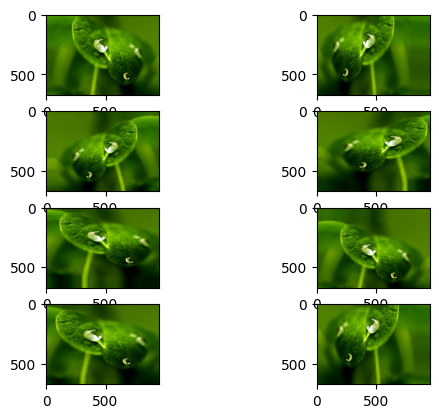

то же самое без сохранения


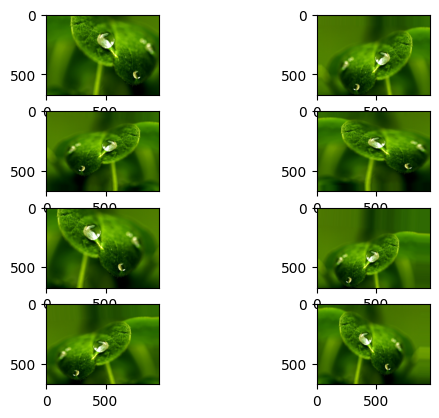

In [6]:
!rm  $augm_dir/*.*
# the .flow() command below generates batches of randomly transformed images
# and saves the results to the `augm_dir` directory
datagen = ImageDataGenerator(
        rotation_range=5,
        width_shift_range=0.15,
        height_shift_range=0.15,
        # сдвиговые преобразования
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')
i = 0
for batch in datagen.flow(
        t, batch_size=1,
        save_to_dir=augm_dir, save_prefix='dew-2208', save_format='jpeg'):
    i += 1
    if i > 7:
        break  # otherwise the generator would loop indefinitely

for i,fn in enumerate(os.listdir(augm_dir),1):
    plt.subplot(4,2,i)
    plt.imshow(load_img(augm_dir+'/'+fn))
plt.show()

# попробуем без сохранения
print('то же самое без сохранения')
for i,batch in enumerate(datagen.flow(t, batch_size=1),1):
    plt.subplot(4,2,i)
    plt.imshow(array_to_img(batch[0]))

    # вот здесь не понял - какое-то странное условие выхода
    # не понял как например дополнить датасет на 20%
    if i >= 8:
        break  # otherwise the generator would loop indefinitely
plt.show()



# Отображатель графиков обучения

In [7]:

class PlotLearning(Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []
        self.inter_dim = []
        self.val_inter_dim = []
        self.logits = []
        self.val_logits = []
        self.acc = []
        self.val_acc = []
        self.fig = plt.figure()

        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        self.i += 1
        f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)

        clear_output(wait=True)

        ax1.set_yscale('log')
        ax1.plot(self.x, self.losses, label="loss:" +
                 str(round(logs.get('loss'), 2)))
        ax1.plot(self.x, self.val_losses, label="v_loss:" +
                 str(round(logs.get('val_loss'), 2)))
        ax1.legend()

        ax2.plot(self.x, self.acc, label="acc:" +
                 str(round(logs.get('accuracy'), 2)))
        ax2.plot(self.x, self.val_acc, label="v_acc:" +
                 str(round(logs.get('val_accuracy'), 2)))
        ax2.legend()

        plt.savefig("fig")
        plt.show()


plot = PlotLearning()



In [8]:
IMG_W = 210
IMG_H = 210

def parse_cls_name(fn):
    s = fn
    return s

def load_data(data_path, test_cnt_per_class, max_per_class = 10):
    classes = []
    x_train = []
    y_train = []
    x_test = []
    y_test = []
    print(data_path)

    dirnames = [fn for fn in os.listdir(data_path)]
    for dir in dirnames:
        x_cls_data = []
        y_cls_data = []
        x_test_data = []
        y_test_data = []
        #print(dir)

        cls_path = os.path.join(data_path, dir)
        fnames = [fn for fn in os.listdir(cls_path) if fn.endswith((".png",".jpg",".bmp"))]

        max_cnt = min(max_per_class, len(fnames))
        i = 0
        for fn in fnames:
            img = cv2.imread(os.path.join(cls_path, fn))
            if img is None:
                continue
            img = cv2.resize(img,(IMG_W, IMG_H))
            cls_name = parse_cls_name(dir)
            try:
                cls_ind = classes.index(cls_name)
            except:
                classes.append(cls_name)
                cls_ind = classes.index(cls_name)
            x_cls_data.append(img)
            y_cls_data.append(cls_ind)
            i += 1
            if i >= max_cnt:
                break

        for i in range(test_cnt_per_class):
            x = x_cls_data.pop()
            y = y_cls_data.pop()
            x_test_data.append(x)
            y_test_data.append(y)

        x_train.extend(x_cls_data)
        y_train.extend(y_cls_data)
        x_test.extend(x_test_data)
        y_test.extend(y_test_data)

    x_data_np = np.asarray(x_train)
    y_data_np = np.asarray(y_train)
    x_test_data_np = np.asarray(x_test)
    y_test_data_np = np.asarray(y_test)
    #x_data_np = np.expand_dims(x_data_np, axis=3)
    #y_data_np = np.asarray(y_train)
    return x_data_np, y_data_np, x_test_data_np, y_test_data_np, classes


classes = []
x_train, y_train, x_test, y_test, classes = load_data(os.path.join(data_dir, ds_name), 20, 500)

num_classes = len(classes)

#plt.hist(y_test, num_classes)
#plt.show()
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')

x_train /= 255
x_test /= 255

print('x_train shape:', x_train.shape)
print('x_test shape:', x_test.shape)
print(x_train.shape[0], 'train samples')
print(num_classes,'classes')
print('y_train shape:', y_train.shape)
print('y_test shape:', y_test.shape)


datasets/dataset
x_train shape: (4864, 210, 210, 3)
x_test shape: (220, 210, 210, 3)
4864 train samples
11 classes
y_train shape: (4864, 11)
y_test shape: (220, 11)


In [9]:
print(classes)

['lightning', 'dew', 'frost', 'sandstorm', 'rainbow', 'glaze', 'rime', 'fogsmog', 'hail', 'rain', 'snow']


In [10]:
y_train[0]

array([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

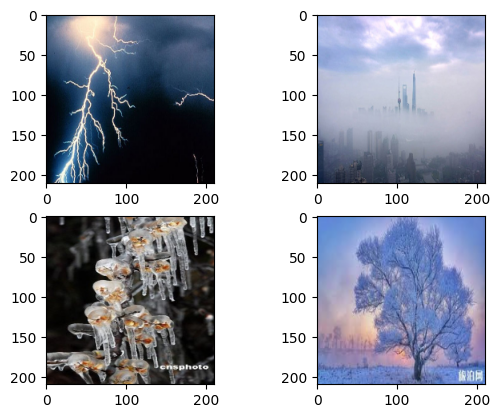

In [11]:
# случайные картинки
for i in range(1,5):
    plt.subplot(2,2,i)
    plt.imshow(cv2.cvtColor(
        x_train[random.randint(0,len(x_train)-1)],
        cv2.COLOR_BGR2RGB))

# Создание и обучение модели
Создаем и обучаем сверточную сеть

In [12]:
model = Sequential([
    #keras.layers.Flatten(input_shape=(32,32,3))),
    keras.layers.InputLayer((IMG_H, IMG_H, 3)),
    # аугментация как часть модели
    keras.layers.RandomFlip("horizontal"),
    #5 градусов - это 2*math.pi/360*5 = 0.09
    keras.layers.RandomRotation(0.09),
    keras.layers.RandomTranslation(width_factor=0.2,height_factor=0.2),
    keras.layers.RandomZoom(0.2),

])

model.add(Conv2D(32, (5,5), padding='same')) #, padding='same'
model.add(BatchNormalization())
model.add(ReLU())
#model.add(Dropout(0.3))

model.add(MaxPooling2D(2,2))

model.add(Conv2D(32, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(ReLU())

model.add(Conv2D(48, (3,3), padding='same'))
model.add(BatchNormalization())

model.add(MaxPooling2D(2,2))

model.add(Conv2D(48, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(ReLU())

model.add(Conv2D(48, (3,3), padding='same'))
model.add(BatchNormalization())
model.add(ReLU())

model.add(MaxPooling2D(2,2))

model.add(Flatten())

model.add(Dense(128))
model.add(ReLU())
model.add(Dropout(0.5))

model.add(Dense(64))
model.add(ReLU())
model.add(Dropout(0.5))
#model.add(BatchNormalization())

model.add(Dense(32))
model.add(ReLU())

model.add(Dense(num_classes))
model.add(Activation('softmax'))

# initiate optimizer
#opt = keras.optimizers.Adam(0.001)
opt = keras.optimizers.AdamW(0.001)

# Let's train the model using RMSprop
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ random_flip (RandomFlip)             │ (None, 210, 210, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_rotation (RandomRotation)     │ (None, 210, 210, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_translation                   │ (None, 210, 210, 3)         │               0 │
│ (RandomTranslation)                  │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ random_zoom (RandomZoom)             │ (None, 210, 210, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 210, 210, 32)        │           2,432 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 210, 210, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu (ReLU)                         │ (None, 210, 210, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 105, 105, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 105, 105, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 105, 105, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_1 (ReLU)                       │ (None, 105, 105, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 105, 105, 48)        │          13,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 105, 105, 48)        │             192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 52, 52, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 52, 52, 48)          │          20,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 52, 52, 48)          │             192 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_2 (ReLU)                       │ (None, 52, 52, 48)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 52, 52, 48)          │          20,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 52, 52, 48)          │             1

 Total params: 4,232,123 (16.14 MB)

 Trainable params: 4,231,707 (16.14 MB)

 Non-trainable params: 416 (1.62 KB)

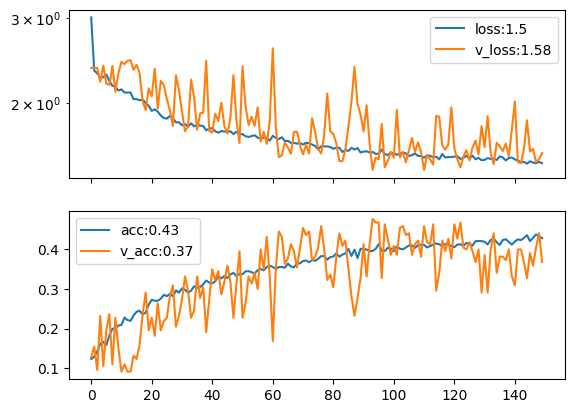

61/61 ━━━━━━━━━━━━━━━━━━━━ 20s 309ms/step - accuracy: 0.4389 - loss: 1.4889 - val_accuracy: 0.3682 - val_loss: 1.5769


'\nprint(\'Using data augmentation.\')\ndatagen = ImageDataGenerator(\n        featurewise_center=False,  # set input mean to 0 over the dataset\n        samplewise_center=False,  # set each sample mean to 0\n        featurewise_std_normalization=False,  # divide inputs by std of the dataset\n        samplewise_std_normalization=False,  # divide each input by its std\n        zca_whitening=False,  # apply ZCA whitening\n        zca_epsilon=1e-06,  # epsilon for ZCA whitening\n        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)\n        # randomly shift images horizontally (fraction of total width)\n        width_shift_range=0.1,\n        # randomly shift images vertically (fraction of total height)\n        height_shift_range=0.1,\n        shear_range=0.,  # set range for random shear\n        zoom_range=0.,  # set range for random zoom\n        channel_shift_range=0.,  # set range for random channel shifts\n        # set mode for filling points outside

In [13]:
#print('Not using data augmentation.')
batch_size =80
epochs = 150



print(y_train.shape)
model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=(x_test, y_test),
          shuffle=True,
          callbacks=[plot]
          )
'''
print('Using data augmentation.')
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=0,  # randomly rotate images in the range (degrees, 0 to 180)
        # randomly shift images horizontally (fraction of total width)
        width_shift_range=0.1,
        # randomly shift images vertically (fraction of total height)
        height_shift_range=0.1,
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=False,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.0)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
model.fit(datagen.flow(x_train, y_train,
                                     batch_size=batch_size),
                        epochs=epochs,
                        validation_data=(x_test, y_test),
                        callbacks=[plot])
'''

# Отображение результата
Отобразим результат распознавания 10 случайных тестовых изображений

In [14]:
from matplotlib.colors import Colormap
from mpl_toolkits.axes_grid1 import ImageGrid
import numpy as np
import random

def get_class_sample(cls_index):
    for i in range(len(y_train)):
        if np.argmax(y_train[i]) == cls_index:
            return x_train[i]
    return None

print("          GT class           Predicted class")

for i in range(10):
    plt.set_cmap(Colormap("Greys"))
    fig = plt.figure(1, (4., 4.))
    grid = ImageGrid(fig, 111,
                 nrows_ncols=(1, 2),
                 axes_pad=0.1,
                 )

    images = []
    np_images = []
    k = random.randint(0,len(x_test)-1)
    images.append(np.expand_dims(x_test[k], axis=0))
    np_images = np.vstack(images)
    y = model.predict(np_images)

    c = np.argmax(y[0])

    cls_name_pred = c
    cls_name_gt = np.argmax(y_test[k])

    img = x_test[k]
    img_pred = get_class_sample(cls_name_pred)
    grid[0].imshow(np.reshape(img,(IMG_H,IMG_W,3)))
    grid[0].set_title("{}".format(cls_name_gt))
    grid[1].imshow(np.reshape(img_pred,(IMG_H,IMG_W,3)))
    grid[1].set_title("{}".format(cls_name_pred))

    plt.show()



Output hidden; open in https://colab.research.google.com to view.

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━

<Axes: >

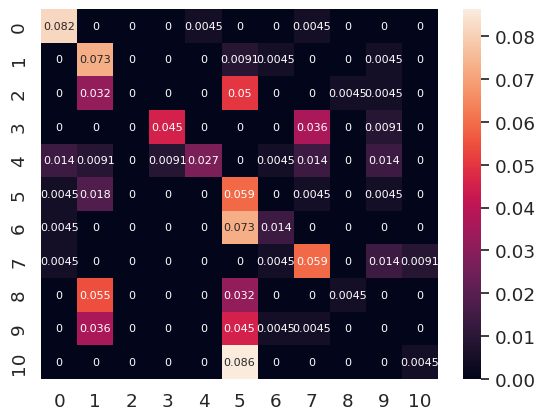

In [15]:
import pandas as pd
import seaborn as sn

def get_conf_matrix(x_test, y_test):
    m = np.zeros((num_classes,num_classes))
    acc = 0
    i = 0
    for x in x_test:
        yp = np.argmax(model.predict(np.expand_dims(x, axis=0)))
        m[np.argmax(y_test[i]),yp] += 1
        i = i+1
    m = m/len(y_test)

    return m

m = get_conf_matrix(x_test[:1000], y_test[:1000])
df_cm = pd.DataFrame(m, range(num_classes), range(num_classes))
sn.set(font_scale=1.2) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 8})

Загрузим и классифицируем произвольное изображение

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
mushrooms  photo_2025-03-16_17-17-54.jpg  weather.zip
(1280, 960, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.00179627 0.02037941 0.17171165 0.00184771 0.00262262 0.2824219
  0.06319083 0.0051128  0.1572763  0.13359623 0.1600443 ]]
glaze


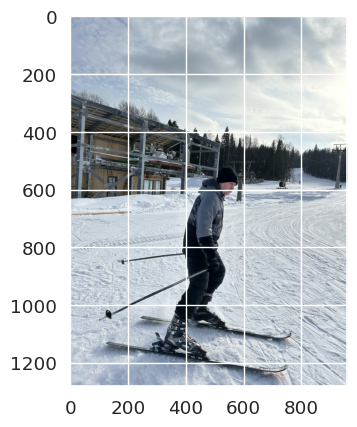

In [16]:
import cv2
from google.colab import drive
drive.mount('/content/drive')
!ls /content/drive/MyDrive/datasets

img = cv2.imread("/content/drive/MyDrive/datasets/photo_2025-03-16_17-17-54.jpg")
print(img.shape)

img_bak = img.copy()
img = img[...,::-1]
img = cv2.resize(img,(IMG_H,IMG_H))
img = img.astype("float32")/255
y = model.predict(np.expand_dims(img,0))
print(y)
print(classes[np.argmax(y)])

img_bak = cv2.cvtColor(img_bak, cv2.COLOR_BGR2RGB)
plt.imshow(img_bak)

доля правды в этом есть - глазурь, гололёд